## Reading in packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from numpy import asarray
from numpy import savetxt
import matplotlib.colors as mcolors
import matplotlib.cm
import matplotlib.patches as mpatches
import umap

import scanpy as sc

## Read in data

Select either the whole sc transformed dataset or just the variable genes

In [2]:
ILC_var = sc.read("sct_variable.h5ad")
#ILC = sc.read("sct.h5ad")

c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
c:\users\hmkri\desktop\riesenfeld pearson\lib\site-packages\anndata\compat\__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [3]:
norm_reads_sparse = ILC_var.layers["norm_data"]
norm_reads = pd.DataFrame(norm_reads_sparse.toarray())
print("Norm reads: "+repr(norm_reads.shape))

UMAP = ILC_var.obsm["umap_cell_embeddings"]
Diff = ILC_var.obsm['X_draw_graph_fa']

Norm reads: (26877, 3000)


## Selecting all ILC2 and ILC3 cells

### Run if writing csv files

In [4]:
Variable = ILC_var.var

Obs = ILC_var.obs
O = Obs["ilc2_ilc3"].to_frame()

Variable["Selected"].to_csv('Gene_list_ILC.csv', sep=',')
O.to_csv('Cell_list_ILC.csv', sep=',')

### Run if reading csv files

In [5]:
Gene_list = pd.read_csv("Gene_list_ILC.csv", sep=",", header = 0)
Gene_list = np.array(Gene_list)
Gene_list = Gene_list[:,0]
Cell_list = pd.read_csv("Cell_list_ILC.csv", sep=",", header = 0)
Cell_list = np.array(Cell_list)
Cell_list = Cell_list[:,0]

print("Gene list:"+repr(Gene_list))
print("Cell list:"+repr(Cell_list))

Gene list:array(['Yfp', 'Rb1cc1', 'Mcmdc2', ..., 'mt-Cytb', 'AC149090.1',
       'Cre (Il5)'], dtype=object)
Cell list:array(['Timept0.AAACCCAAGCTATCTG', 'Timept0.AAACCCAAGGTAATCA',
       'Timept0.AAACCCAAGTCTAACC', ..., 'Timept4.TTTGTTGCATCCAATG',
       'Timept4.TTTGTTGTCATTCATC', 'Timept4.TTTGTTGTCGCACTCT'],
      dtype=object)


## Collecting cells of interest

In this model of psoriasis, tissue resident ILC2s are reprogramed to ILC3s. 

For analysis we are selecting for cells likely to be ILC2s or ILC3s on the basis of previously characterized populations.

In [6]:
#We have four labeled groups of cells that we want to collect together
ILC2_ILC3 = ILC_var.obs["ilc2_ilc3"]
ILC3_Q = ILC_var.obs["quiescent_ilc3"]
ILC2_Q = ILC_var.obs["ilc2_quiescent"]
cloud_ILC3 = ILC_var.obs["cloud_ilc3"]

df = pd.DataFrame(dict(ILC2_ILC3 = ILC2_ILC3, ILC3_Q = ILC3_Q, ILC2_Q = ILC2_Q, cloud_ILC3 = cloud_ILC3))
cells = df.shape[0]

In [7]:
#binary yes ir no for if the cell is in our group
in_transition = np.zeros((cells, 1))

#Value of group - 0 if NA - over all cells
allcell_ILC2_ILC3 = np.zeros((cells, 1))
allcell_ILC3_Q = np.zeros((cells, 1))
allcell_ILC2_Q = np.zeros((cells, 1))
allcell_cloud_ILC3 = np.zeros((cells, 1))

#Cell labels - 0 if NA in all groups - over all cells
index_cells = np.zeros((cells, 1))
index_cells = index_cells.astype(str)

#Value of group - only cells in at least one group
val_ILC2_ILC3 = np.zeros((3807, 1))
val_ILC3_Q = np.zeros((3807, 1))
val_ILC2_Q = np.zeros((3807, 1))
val_cloud_ILC3 = np.zeros((3807, 1))

#Names of cells included in the value variables
index_val = np.array([])

#Variable for initially counting the number of cells in the groups of interest
number = 0


#Loops through the different groups so that we collect all cells with a value in at least one of the groups
for i in range(0,cells):
    if np.isnan(df["ILC2_ILC3"][i]):

        if np.isnan(df["ILC3_Q"][i]):

            if np.isnan(df["ILC2_Q"][i]):

                if np.isnan(df["cloud_ILC3"][i]):

                    in_transition[i,0] = 0
                    
                    allcell_ILC2_ILC3[i,0] = 0
                    allcell_ILC3_Q[i,0] = 0
                    allcell_ILC2_Q[i,0] = 0
                    allcell_cloud_ILC3[i,0] = 0
                    
                    index_cells[i,0] = "0"
                    
                else:
                    in_transition[i,0] = 1
                    
                    allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                    allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                    allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                    allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                    
                    index_cells[i,0] = Cell_list[i]
                    
                    val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                    val_ILC3_Q[number] = df["ILC3_Q"][i]
                    val_ILC2_Q[number] = df["ILC2_Q"][i]
                    val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                    
                    index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                    
                    number += 1
            else:
                in_transition[i,0] = 1
                
                allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
                allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
                allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
                allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
                
                index_cells[i,0] = Cell_list[i]
                
                val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
                val_ILC3_Q[number] = df["ILC3_Q"][i]
                val_ILC2_Q[number] = df["ILC2_Q"][i]
                val_cloud_ILC3[number] = df["cloud_ILC3"][i]
                
                index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
                
                number += 1             

        else:
            in_transition[i,0] = 1
            
            allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
            allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
            allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
            allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
            
            index_cells[i,0] = Cell_list[i]
            
            val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
            val_ILC3_Q[number] = df["ILC3_Q"][i]
            val_ILC2_Q[number] = df["ILC2_Q"][i]
            val_cloud_ILC3[number] = df["cloud_ILC3"][i]
            
            index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
            
            number += 1
    
    else:
        in_transition[i,0] = 1
        
        allcell_ILC2_ILC3[i,0] = df["ILC2_ILC3"][i]
        allcell_ILC3_Q[i,0] = df["ILC3_Q"][i]
        allcell_ILC2_Q[i,0] = df["ILC2_Q"][i]
        allcell_cloud_ILC3[i,0] = df["cloud_ILC3"][i]
        
        index_cells[i,0] = Cell_list[i]
        
        val_ILC2_ILC3[number] = df["ILC2_ILC3"][i]
        val_ILC3_Q[number] = df["ILC3_Q"][i]
        val_ILC2_Q[number] = df["ILC2_Q"][i]
        val_cloud_ILC3[number] = df["cloud_ILC3"][i]
        
        index_val = np.append(index_val , df["ILC2_ILC3"].index[i])
        
        number += 1
      

print(number)

3807


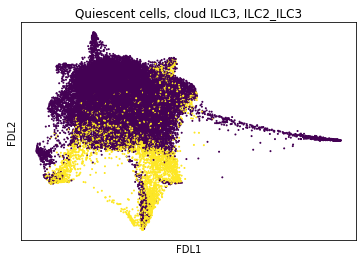

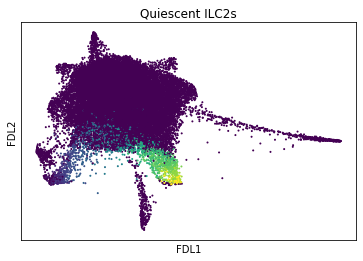

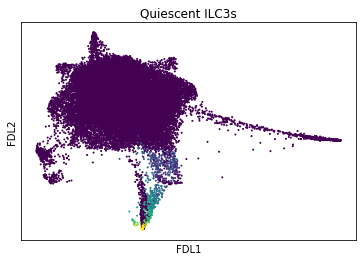

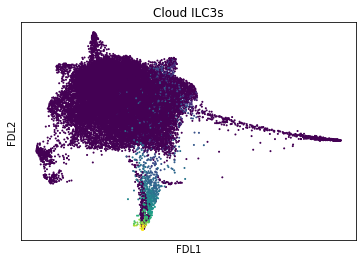

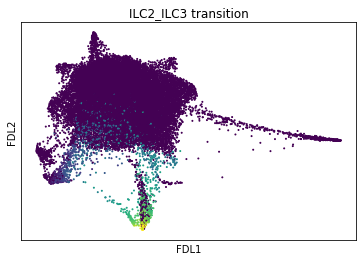

In [8]:
#There are some nan values in these arrays that we want to force to zero
val_ILC2_ILC3[np.isnan(val_ILC2_ILC3)] = 0
val_ILC3_Q[np.isnan(val_ILC3_Q)] = 0
val_ILC2_Q[np.isnan(val_ILC2_Q)] = 0
val_cloud_ILC3[np.isnan(val_cloud_ILC3)] = 0  

frame1 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = in_transition)
plt.title('Quiescent cells, cloud ILC3, ILC2_ILC3')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame2 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_Q)
plt.title('Quiescent ILC2s')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame3 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC3_Q)
plt.title('Quiescent ILC3s')
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame4 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_cloud_ILC3)
plt.title('Cloud ILC3s')
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

frame5 = plt.scatter(Diff[:,0], Diff[:,1], s= 1, c = allcell_ILC2_ILC3)
plt.title('ILC2_ILC3 transition')
frame5.axes.get_xaxis().set_ticks([])
frame5.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

### Creating normalized read matrix for only the cells of interest

In [9]:
#Numpy array with normalized reads for all cells
norm_reads = np.array(norm_reads)

#Number of genes to initialize new matrix
genes = Gene_list.shape[0]
reads = np.zeros((1,genes))

#Going through all of the cells, if the  associated index in index_cell is nonzero then 
#it was included in our group and we should pull the associated gene expression data
for i in range(0,cells):
    j = index_cells[i]
    if j != "0":
        next_cell = norm_reads[i,:]
        next_cell = np.reshape(next_cell, (1,3000))
        reads = np.append(reads, next_cell, axis = 0)

#To get the indices to work out I have a row of zeros at the top that I need to omit
reads = reads[1:, :]        

# Save or read in matrix with cells of interest

In [10]:
np.savetxt("ILCs_reads.csv", reads, delimiter=',')
np.savetxt("ILCs_index.csv", index_val, delimiter=',', fmt="%s")
np.savetxt("index_cells.csv", index_cells, delimiter=',', fmt="%s")

In [11]:
ILCs_reads = pd.read_csv("ILCs_reads.csv", sep=",", header = None) #Normalized gene expression of cells of interest
ILCs_reads_values = np.array(ILCs_reads)

ILCs_index = pd.read_csv("ILCs_index.csv", sep=",", header = None)

### UMAP of selected cells

In [12]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(ILCs_reads_values)
embedding.shape

(3807, 2)

In [13]:
#np.savetxt("UMAP_all_ILC_norm.csv", embedding, delimiter=',')
embedding = pd.read_csv("UMAP_all_ILC_norm.csv", sep=",", header = None)
embedding = np.array(embedding)

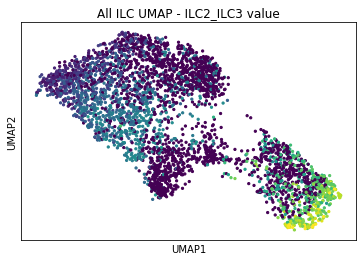

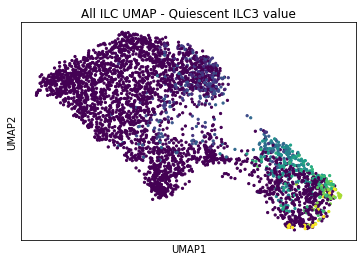

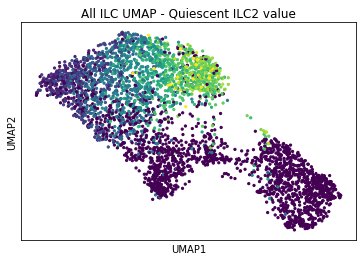

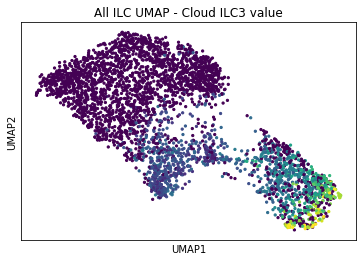

In [14]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC2_ILC3)
plt.title('All ILC UMAP - ILC2_ILC3 value')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame2 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC3_Q)
plt.title('All ILC UMAP - Quiescent ILC3 value')
#plt.xlim(-30000,25000)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame3 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_ILC2_Q)
plt.title('All ILC UMAP - Quiescent ILC2 value')
#plt.xlim(-30000,25000)
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame4 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = val_cloud_ILC3)
plt.title('All ILC UMAP - Cloud ILC3 value')
#plt.xlim(-30000,25000)
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()


### To look at individual genes on this UMAP

In [15]:
#To look at expression of individual genes on the UMAP we pull the index from our Gene_list

G = "Il4"
Gene_list = np.array(Gene_list)

for i in range(0,genes):
    if Gene_list[i] == G:
        gene_index = i

print(str(G)+' index: '+str(gene_index))

Il4 index: 2018


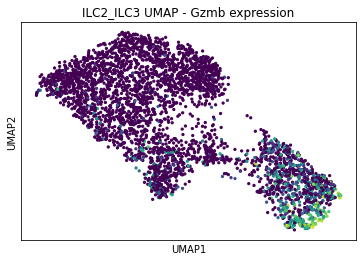

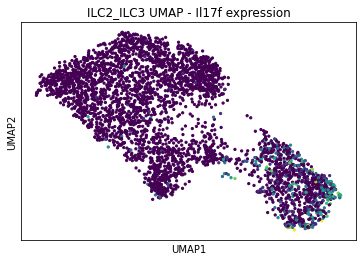

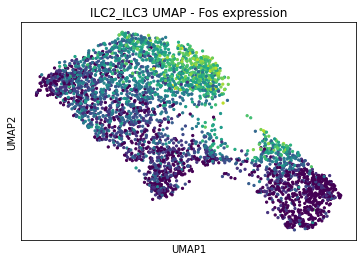

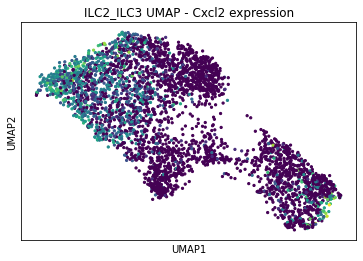

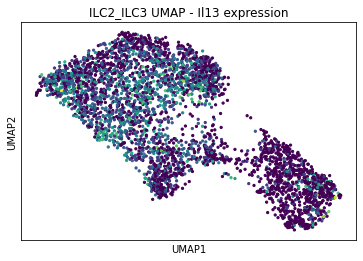

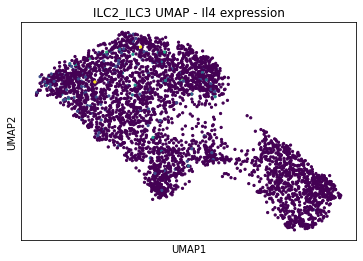

In [16]:
frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,1722])
plt.title('ILC2_ILC3 UMAP - Gzmb expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,8])
plt.title('ILC2_ILC3 UMAP - Il17f expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2427])
plt.title('ILC2_ILC3 UMAP - Fos expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,881])
plt.title('ILC2_ILC3 UMAP - Cxcl2 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2019])
plt.title('ILC2_ILC3 UMAP - Il13 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

frame1 = plt.scatter(embedding[:,0], embedding[:,1], s= 5, c = ILCs_reads_values[:,2018])
plt.title('ILC2_ILC3 UMAP - Il4 expression')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()

## Preprocessing

In [17]:
center = np.argsort(val_ILC2_ILC3)[val_ILC2_ILC3.shape[0]//2]
print(center)

[0]


In [18]:
from manifold_utils.mSVD import eigen_plot, eigen_calc_from_dist_mat, eps_projection

ILCs_index = np.array(ILCs_index)

ILCs = ILCs_reads_values
N, d = ILCs.shape

In [19]:
dist_mat = np.zeros((N, N))
for j in range(0,N):
    for k in range(0,N):
        if j != k:
            dist_mat[j, k] = np.linalg.norm(ILCs[j, :] - ILCs[k, :])

In [20]:
print(dist_mat.shape)

savetxt('dist_mat_allILC.csv', dist_mat, delimiter=',')

#dist_mat = pd.read_csv('dist_mat_allILC.csv', sep=",", header = None)
#dist_mat = np.array(dist_mat )

(3807, 3807)


Applying preproccessing to matrix - ILC_gene_expression_values

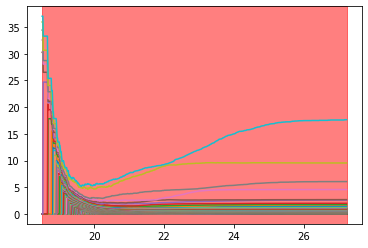

In [21]:
center = 0
radii, eigval_list, _ = eigen_calc_from_dist_mat(ILCs, dist_mat, center)

rmin = radii[0]
rmax = radii[-1]

eigen_plot(eigval_list, radii, rmin, rmax)

In [22]:
(22 - rmin)/0.01

348.96770480442854

In [23]:
evec = _[349][:,0:2]
print(evec.shape)

(3000, 2)


In [28]:
center = 0
center_val = 0
proj = eps_projection(ILCs,evec,ILCs[center, :])

In [29]:
proj

array([[ 0.00000000e+00,  0.00000000e+00],
       [ 2.17170032e-14, -3.16899285e-14],
       [-1.67746025e-13,  3.48401863e-14],
       ...,
       [-9.31972803e-02, -2.58789840e-02],
       [-4.59269775e-13,  1.67208261e-13],
       [ 4.88528042e-02, -5.02381726e-02]])

In [30]:
p = np.array(proj)

savetxt('eps_projection_allILC.csv', p, delimiter=',')

In [31]:
in_ball = np.zeros(val_ILC2_ILC3.shape)

for i in range(0,3807):
    if dist_mat[i, center_val] < 22:
        in_ball[i] = 1
    else:
        in_ball[i] = 0
        
#in_ball = np.reshape(in_ball, (val_ILC2_ILC3.shape))

In [32]:
A = np.multiply(in_ball, val_ILC2_ILC3)
print(A.shape)

(3807, 1)


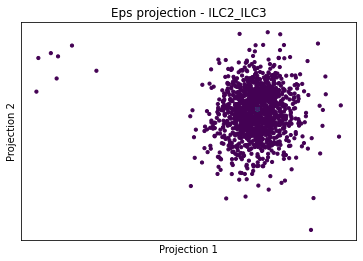

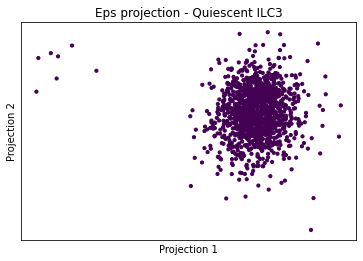

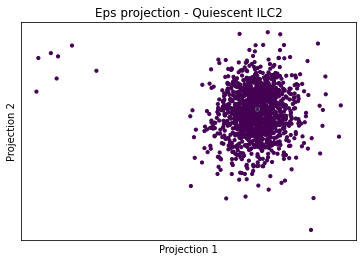

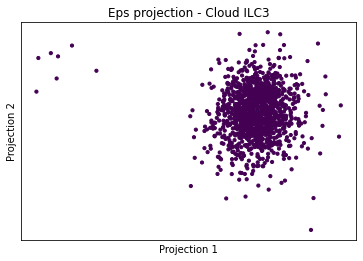

In [33]:
frame1 = plt.scatter(p[:,0], p[:,1], s = 10, c = np.multiply(in_ball,val_ILC2_ILC3))
plt.title('Eps projection - ILC2_ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame2 = plt.scatter(p[:,0], p[:,1], s = 10, c = np.multiply(in_ball,val_ILC3_Q))
plt.title('Eps projection - Quiescent ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame2.axes.get_xaxis().set_ticks([])
frame2.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame3 = plt.scatter(p[:,0], p[:,1], s = 10, c = np.multiply(in_ball,val_ILC2_Q))
plt.title('Eps projection - Quiescent ILC2')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame3.axes.get_xaxis().set_ticks([])
frame3.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

frame4 = plt.scatter(p[:,0], p[:,1], s = 10, c = np.multiply(in_ball,val_cloud_ILC3))
plt.title('Eps projection - Cloud ILC3')
#plt.xlim(-0.1,0.1)
#plt.ylim(-0.1,0.1)
frame4.axes.get_xaxis().set_ticks([])
frame4.axes.get_yaxis().set_ticks([])
plt.ylabel('Projection 2')
plt.xlabel('Projection 1')
plt.show()

## Visualizing centers

In [34]:
in_transition

array([[1.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [35]:
center = np.ones(cells)
counter = 0

for i in range(0,cells):
    if in_transition[i] == 1:
        counter += 1
        if counter == center_val:
            print(i)
            break

index = 0
for j in range(0,cells):
    if in_transition[j] == 1:
        print(index)
                    
        if dist_mat[index, center_val] < 20:
            center[j] = 4.0
            
        elif dist_mat[index, center_val] < 22.5:
            center[j] = 3.0
            
        elif dist_mat[index, center_val] < 25:
            center[j] = 2.0
        
        elif dist_mat[index, center_val] < 30:
            center[j] = 1.0
        index += 1

    else:
        center[j] = 0.0
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806


In [36]:
dist_mat[center_val,center_val]

0.0

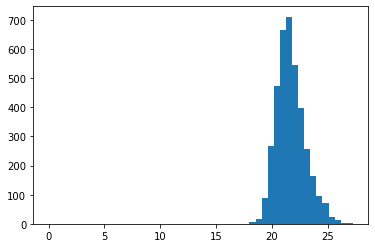

In [37]:
frame1 = plt.hist(dist_mat[0,:], bins = 50)

plt.show()

In [38]:
print(dist_mat[1, center_val]<21.5)

print(np.amax(dist_mat[:, center_val]))
print(np.amin(dist_mat[:, center_val]))

True
27.22861003596301
0.0


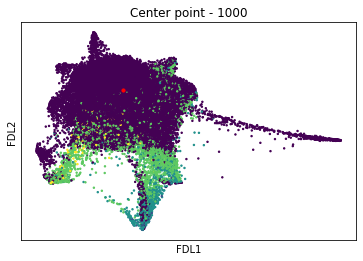

In [39]:
frame1 = plt.scatter(Diff[:,0], Diff[:,1], s=2, c = center)
frame1 = plt.scatter(Diff[i,0], Diff[i,1], s=10, c = "red")
plt.title('Center point - 1000')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('FDL2')
plt.xlabel('FDL1')
plt.show()

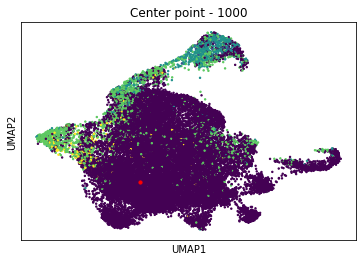

In [40]:
frame1 = plt.scatter(UMAP[:,0], UMAP[:,1], s=2, c = center)
frame1 = plt.scatter(UMAP[i,0], UMAP[i,1], s=10, c = "red")
plt.title('Center point - 1000')
#plt.xlim(-30000,25000)
frame1.axes.get_xaxis().set_ticks([])
frame1.axes.get_yaxis().set_ticks([])
plt.ylabel('UMAP2')
plt.xlabel('UMAP1')
plt.show()